# Import all packages and the used settings and functions

In [2]:
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')


from settings import Settings
from src.functions.data_preprocessing import *
from src.functions.functions_plot import *
from src.functions.regression_pipeline import *

settings = Settings()

# Load training and test dataset

In [26]:
# Load train and test dataset
df_train = pd.read_csv(settings.config['Data Locations'].get('train'))
df_validate = pd.read_csv(settings.config['Data Locations'].get('test'))

df_train.name = 'df_train'
df_validate.name = 'df_validate'

# Explore the data

First take a look at the training dataset
- what are the features and how many features does the training data include
- are the missing values (but take a deeper look at the data preperation process)
- what are the different units of the features

In [4]:
# Get a report of the training and test dataset as csv
# -> Use the function describe_report(df, name, output_file_path=None)

describe_report(df_train, output_file_path=settings.csv)
describe_report(df_validate, output_file_path=settings.csv)

In [5]:
# Show if there are different columns in the training and test dataset. If there is only one difference, it is likely, that its the target variable.
# If there are columns in the test dataset, which are not in the training dataset, they have to be deleted, because the algorithm will not see them during the training.
# -> Use the function column_diff(df_train, df_test)

column_diff(df_train, df_validate)

Columns in df_train not in df_validate
Index(['dropoff_datetime', 'trip_duration'], dtype='object')
##################
Columns in df_validate not in df_train
Index([], dtype='object')


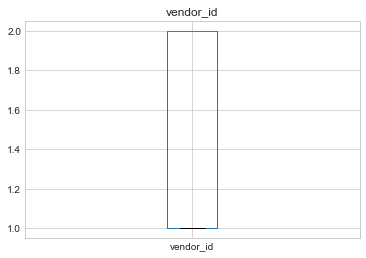

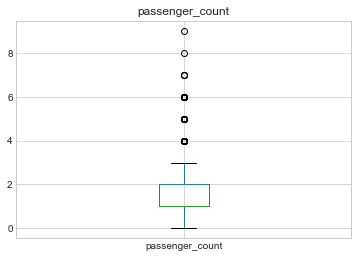

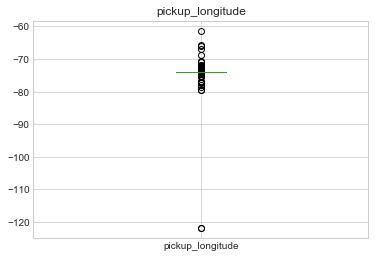

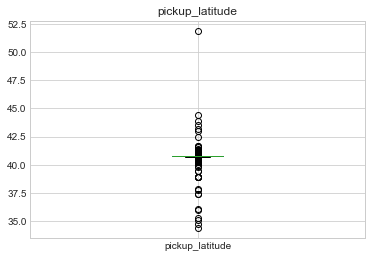

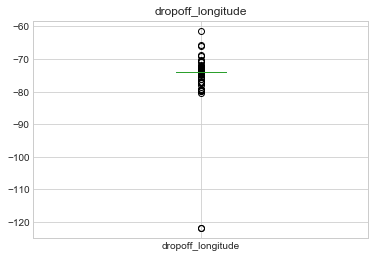

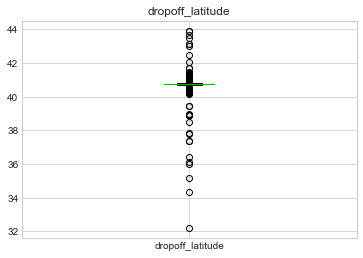

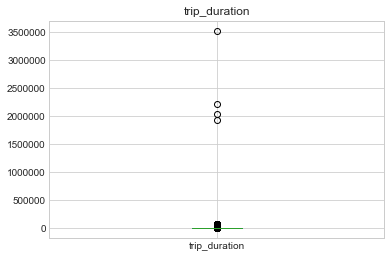

In [6]:
# Create boxplots to indentify outliers. Histograms are a good standard way to see if feature is skewed but to find outliers, boxplots are the way to use
# -> Use the function create_boxplots(df, output_file_path=None)

create_boxplots(df_train, output_file_path=settings.figures)

In [7]:
# create map with trips

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values, df_train['pickup_latitude'].values,
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(df_validate['pickup_longitude'].values, df_validate['pickup_latitude'].values,
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [8]:
# Create cluster trips into MiniBatches and plot cluster on map

from sklearn.cluster import MiniBatchKMeans

df_train['pickup_cluster'] = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit_predict(
    df_train[['pickup_latitude', 'pickup_longitude']])
df_train['dropoff_cluster'] = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit_predict(
    df_train[['dropoff_latitude', 'dropoff_longitude']])

df_validate['pickup_cluster'] = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit_predict(
    df_validate[['pickup_latitude', 'pickup_longitude']])
df_validate['dropoff_cluster'] = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit_predict(
    df_validate[['dropoff_latitude', 'dropoff_longitude']])

cm = plt.cm.get_cmap('RdYlBu')
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df_train.pickup_longitude.values, df_train.pickup_latitude.values, c=df_train.pickup_cluster.values,
           alpha=0.2, s=10, cmap=cm)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Feature Creation

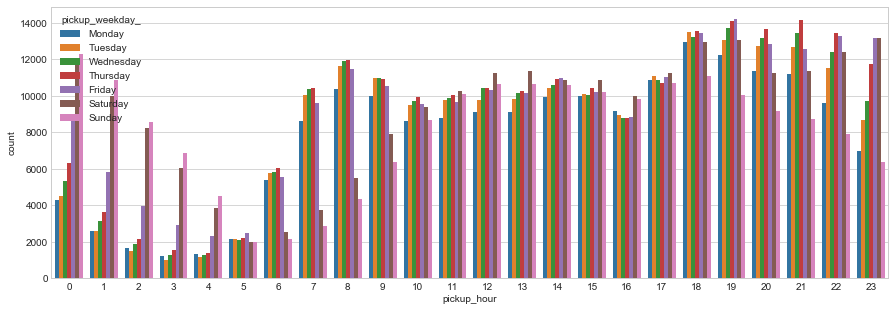

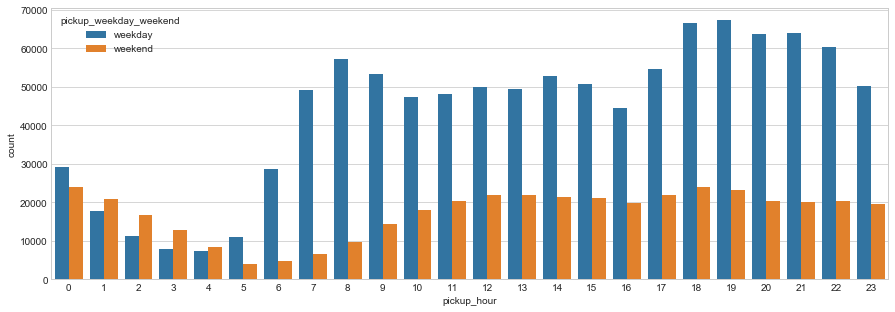

In [9]:
# Format to daytime
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train['dropoff_datetime'] = pd.to_datetime(df_train.dropoff_datetime)

df_validate['pickup_datetime'] = pd.to_datetime(df_validate.pickup_datetime)


# get date, weekday, day, month, hour, minute
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['pickup_weekday'] = df_train['pickup_datetime'].dt.weekday
df_train['pickup_day'] = df_train['pickup_datetime'].dt.day
df_train['pickup_month'] = df_train['pickup_datetime'].dt.month
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_minute'] = df_train['pickup_datetime'].dt.minute

df_validate['pickup_date'] = df_validate['pickup_datetime'].dt.date
df_validate['pickup_weekday'] = df_validate['pickup_datetime'].dt.weekday
df_validate['pickup_day'] = df_validate['pickup_datetime'].dt.day
df_validate['pickup_month'] = df_validate['pickup_datetime'].dt.month
df_validate['pickup_hour'] = df_validate['pickup_datetime'].dt.hour
df_validate['pickup_minute'] = df_validate['pickup_datetime'].dt.minute


df_train['pickup_weekday_'] = df_train['pickup_weekday'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
     4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

df_train['pickup_weekday_weekend'] = df_train['pickup_weekday'].replace({0: 'weekday', 1: 'weekday', 2: 'weekday', 3: 'weekday',
     4: 'weekday', 5: 'weekend', 6: 'weekend'})

plt.figure(figsize=(15, 5))
sns.countplot(x='pickup_hour', hue='pickup_weekday_', data=df_train,
              hue_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                         'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 5))
sns.countplot(x='pickup_hour', hue='pickup_weekday_weekend', data=df_train, hue_order=['weekday', 'weekend'])

In [10]:
# calculate haversine distance and manhatten distance

def haversine_distance(lat1, lng1, lat2, lng2):

    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h # in km


def manhattan_distance(lat1, lng1, lat2, lng2):

    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b

df_train['distance_haversine'] = haversine_distance(
        df_train['pickup_latitude'].values, df_train['pickup_longitude'].values,
        df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

df_validate['distance_haversine'] = haversine_distance(
    df_validate['pickup_latitude'].values, df_validate['pickup_longitude'].values,
    df_validate['dropoff_latitude'].values, df_validate['dropoff_longitude'].values)


df_train['distance_manhattan'] = manhattan_distance(
        df_train['pickup_latitude'].values, df_train['pickup_longitude'].values,
        df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

df_validate['distance_manhattan'] = manhattan_distance(
    df_validate['pickup_latitude'].values, df_validate['pickup_longitude'].values,
    df_validate['dropoff_latitude'].values, df_validate['dropoff_longitude'].values)

In [11]:
# calculate directions north <-> south (latutude) and east <-> west (longitude)
# +1 because TRUE and FALSE is represented by 0 and 1 -> +1 to shift representation to 1 and 2 because same latitude represented by 0

df_train['direction_ns'] = (df_train.pickup_latitude>df_train.dropoff_latitude)*1+1
indices = df_train[(df_train.pickup_latitude == df_train.dropoff_latitude) & (df_train.pickup_latitude!=0)].index
df_train.loc[indices,'direction_ns'] = 0

df_validate['direction_ns'] = (df_validate.pickup_latitude>df_validate.dropoff_latitude)*1+1
indices = df_validate[(df_validate.pickup_latitude == df_validate.dropoff_latitude) & (df_validate.pickup_latitude!=0)].index
df_validate.loc[indices,'direction_ns'] = 0

df_train['direction_ew'] = (df_train.pickup_longitude>df_train.dropoff_longitude)*1+1
indices = df_train[(df_train.pickup_longitude == df_train.dropoff_longitude) & (df_train.pickup_longitude!=0)].index
df_train.loc[indices,'direction_ew'] = 0

df_validate['direction_ew'] = (df_validate.pickup_longitude>df_validate.dropoff_longitude)*1+1
indices = df_validate[(df_validate.pickup_longitude == df_validate.dropoff_longitude) & (df_validate.pickup_longitude!=0)].index
df_validate.loc[indices,'direction_ew'] = 0

Text(0,0.5,'average speed')

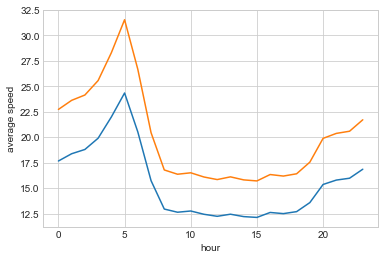

In [12]:
# calculate average speed in training dataset -> average speed in NYC district is the same of test dataset

df_train['avg_speed_h'] = 3600 * df_train['distance_haversine'] / df_train['trip_duration']
df_train['avg_speed_m'] = 3600 * df_train['distance_manhattan'] / df_train['trip_duration']

plt.plot(df_train.groupby('pickup_hour').mean()['avg_speed_h'])
plt.plot(df_train.groupby('pickup_hour').mean()['avg_speed_m'])
plt.xlabel('hour')
plt.ylabel('average speed')

# Feature Selection

In [13]:
df_train = df_train[df_train['avg_speed_h'] < 150]
df_train = df_train[df_train['avg_speed_m'] < 150]


df_train = df_train[df_train['pickup_latitude'] > city_lat_border[0]]
df_train = df_train[df_train['pickup_longitude'] < city_lat_border[1]]

df_train = df_train[df_train['dropoff_latitude'] > city_long_border[0]]
df_train = df_train[df_train['dropoff_longitude'] < city_long_border[1]]

In [20]:
column_diff(df_train, df_validate)

AttributeError: 'DataFrame' object has no attribute 'name'